# Podsumowanie projektu - bike sharing prediction

## Najważniejsze pomysły
+ Podział na zbiór treningowy i testowy.
+ Adam vs SGD jako optymalizator.
+ ReLU/LeakyRelU na wyjściu (nigdy nie chcemy przewidywać ujemnej liczby wypożyczeń).
+ Model z kilkoma warstwami + długie trenowanie.
+ Skalowanie wejść/wyjść - obliczamy skalowanie (np. min/max czy mean/std) na zbiorze treningowym i **te same** wartości stosujemy na zbiorze testowym. 

In [1]:
import torch, torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
import numpy as np
import pandas as pd
import torch.utils.data as data
import seaborn as sns
import matplotlib.pyplot as plt

## Skalowanie wyjść wewnątrz sieci - batch norm


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
train_data = pd.read_csv("../EX3 - BIKE SHARING PREDICTION WITH PYTORCH/data/data.csv",index_col=0)

In [4]:
# wyrzucenie niepotrzebnych kolumn
train = train_data.drop(columns=["casual","registered","cnt","dteday","season","yr","mnth"])
# TensorDataset
train_dataset = data.TensorDataset(torch.from_numpy(train.values).float(), torch.from_numpy(train_data.values[:,-1].astype(float)).float())

In [5]:
data_loader  = data.DataLoader(train_dataset, batch_size=256, shuffle=True)

+ Zwykła sieć neuronowa:

In [6]:
class MyNet(nn.Module):
    def __init__(self): 
        super(MyNet, self).__init__()
        self.lin1 =nn.Linear(9, 48)  # 28 x 28 = 784
        self.act1 =nn.ReLU()
        self.lin2 =nn.Linear(48, 24)
        self.act2 =nn.ReLU()
        self.lin3 =nn.Linear(24, 1)
        
             
    def forward(self, x):
        x = self.lin1(x)
        x = self.act1(x)
        x = self.lin2(x)
        x = self.act2(x)
        x = self.lin3(x)
        return x

+ Sieć neuronowa ze znormalizowanymi wyjściami warstwy:

In [7]:
class MyNetBN(nn.Module):
    def __init__(self): 
        super().__init__()
        self.lin1 =nn.Linear(9, 48)
        self.bn1 = nn.BatchNorm1d(48)    # normalizuje wyjście warstwy neuronowej  
        self.act1 =nn.ReLU()
        self.lin2 =nn.Linear(48, 24)
        self.bn2 = nn.BatchNorm1d(24)
        self.act2 =nn.ReLU()
        self.lin3 =nn.Linear(24, 1)
        
             
    def forward(self, x):
        x = self.lin1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.lin2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.lin3(x)
        return x

In [8]:
model = MyNet()
print(model)

MyNet(
  (lin1): Linear(in_features=9, out_features=48, bias=True)
  (act1): ReLU()
  (lin2): Linear(in_features=48, out_features=24, bias=True)
  (act2): ReLU()
  (lin3): Linear(in_features=24, out_features=1, bias=True)
)


In [9]:
model_bn = MyNetBN()
print(model_bn)

MyNetBN(
  (lin1): Linear(in_features=9, out_features=48, bias=True)
  (bn1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU()
  (lin2): Linear(in_features=48, out_features=24, bias=True)
  (bn2): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU()
  (lin3): Linear(in_features=24, out_features=1, bias=True)
)


+ Użycie ich w praktyce:

In [10]:
loss_fn = nn.MSELoss()
opt = optim.SGD(model.parameters(), lr=0.0001, momentum=0.5)
opt_bn = optim.SGD(model_bn.parameters(), lr=0.0001, momentum=0.5)

+ Oba modele trenujemy naraz zeby porównać:

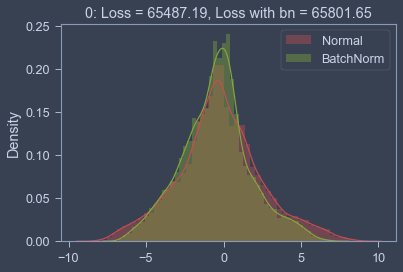

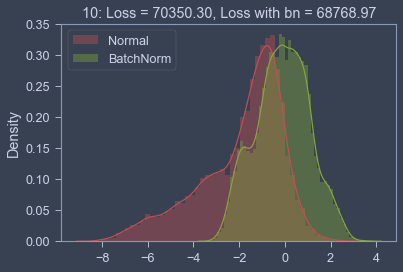

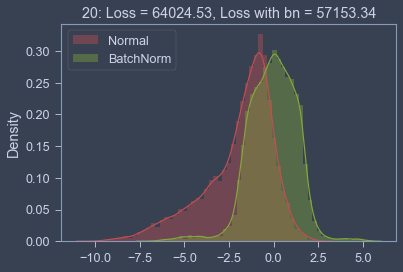

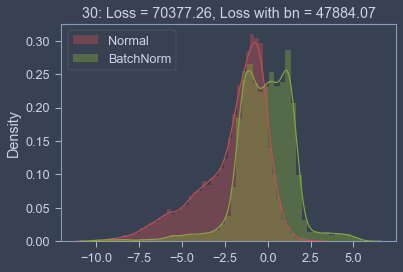

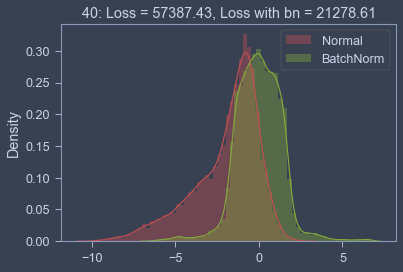

----------------------


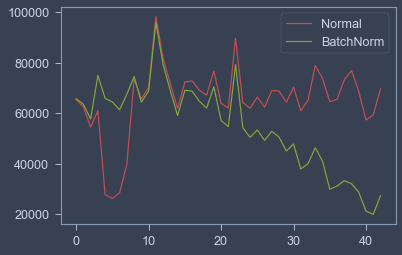

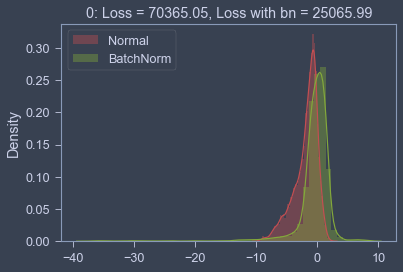

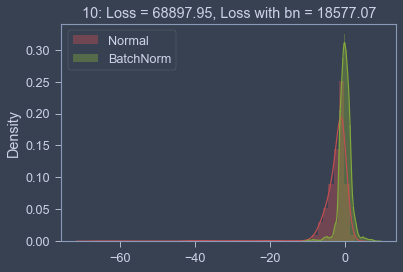

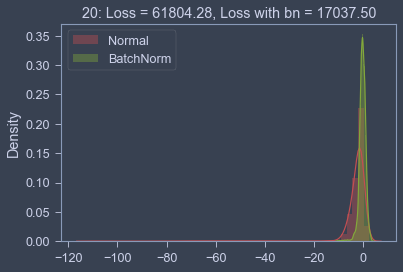

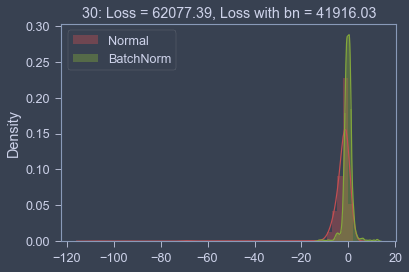

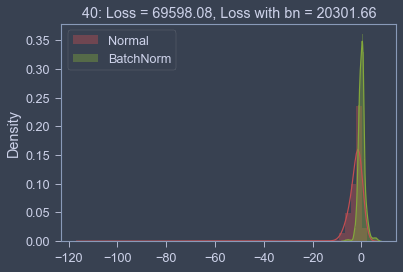

----------------------


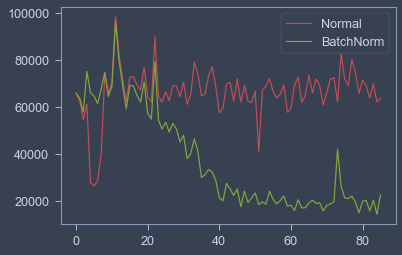

In [11]:
loss_arr = []
loss_bn_arr = []

max_epochs = 2

for epoch in range(max_epochs):
    for i, batch in enumerate(data_loader, 0):

        inputs, labels = batch

        # training steps for normal model
        opt.zero_grad()
        outputs = model(inputs).squeeze()
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        # training steps for bn model
        opt_bn.zero_grad()
        outputs_bn = model_bn(inputs).squeeze()
        loss_bn = loss_fn(outputs_bn, labels)
        loss_bn.backward()
        opt_bn.step()
        
        loss_arr.append(loss.item())
        loss_bn_arr.append(loss_bn.item())
        
        if i % 10 == 0:
        
            inputs = inputs.view(inputs.size(0), -1)
            
            # przelaczanie w tryb ewaluacyjny - modul batch przelaczy sie z
            # wyliczania srednich na korzystanie z tych ktore zapamietal
            model.eval()
            model_bn.eval()
            
            # wykresy tylko przez 1 warstwe liniowa sieci
            a = model.lin1(inputs)
            a = a.detach().numpy().ravel()
            sns.distplot(a, kde=True, color='r', label='Normal') 
            
            b = model_bn.lin1(inputs)
            b = model_bn.bn1(b)
            b = b.detach().numpy().ravel()
            
            sns.distplot(b, kde=True, color='g', label='BatchNorm') 
            plt.title('%d: Loss = %0.2f, Loss with bn = %0.2f' % (i, loss.item(), loss_bn.item()))
            plt.legend()
            plt.show()
            plt.pause(0.5)
            
            model.train()
            model_bn.train()
        
        
    print('----------------------')

    plt.plot(loss_arr, 'r', label='Normal')
    plt.plot(loss_bn_arr, 'g', label='BatchNorm')
    plt.legend()
    plt.show()

## Przeuczanie sieci

+ Wykonujemy poprzez wybranie tylko 20 próbek w trenujacym a prawie 1000 w testowym:

In [7]:
mnist_data = torchvision.datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)
mnist_train = mnist_data[:20]
mnist_val   = mnist_data[20:1000] 

+ Klasyczne zainicjowanie urządzenia GPU i ustawienie seed:

In [3]:
device = torch.device("cuda") 
device

device(type='cuda')

In [4]:
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

+ Model:

In [17]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 800)
        self.act_1 =  nn.Tanh()
        self.layer2 = nn.Linear(800, 800)
        self.act_2 = nn.Tanh()
        self.layer3 = nn.Linear(800, 10)
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        activation1 = self.act_1(self.layer1(flattened))
        activation2 = self.act_2(self.layer2(activation1))
        output = self.layer3(activation2)
        return output

+ Funkcja trenująca:

In [22]:
def train(model, train, valid, batch_size=10, num_epochs=1, learn_rate=0.001, weight_decay=0):
    train_loader = torch.utils.data.DataLoader(train,
                                               batch_size=batch_size,
                                               shuffle=True) # shuffle after every epoch
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learn_rate,momentum=0.9, weight_decay=weight_decay)

    iters, losses, train_acc, val_acc = [], [], [], []

    idx = 0
    for n in range(num_epochs):
        for imgs, labels in iter(train_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            model.train() 
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         

            # save the current training information
            if idx % 10 == 9:
                iters.append(idx)
                losses.append(float(loss)/batch_size)        # compute *average* loss
                train_acc.append(get_accuracy(model, train)) # compute training accuracy 
                val_acc.append(get_accuracy(model, valid))   # compute validation accuracy
            idx+=1
        if n%100==0:
            print(f"Epoch {n}")

            
    # plotting after training
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()


    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

+ Funkcja licząca dokładność modelu:

In [24]:
def get_accuracy(model, data):
    correct = 0
    total = 0
    model.eval() #*********#
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        imgs, labels = imgs.to(device), labels.to(device)
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

+ Zbiory:

In [20]:
train_acc_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100)
val_acc_loader = torch.utils.data.DataLoader(mnist_val, batch_size=1000)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900


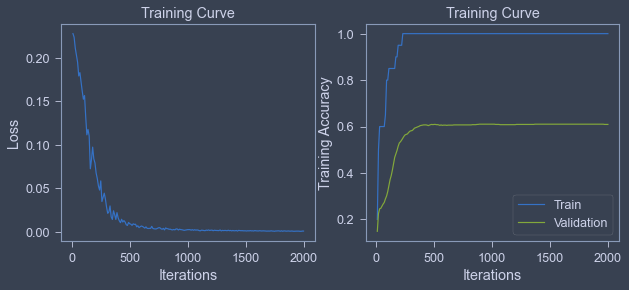

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.6091836734693877


In [21]:
model = MNISTClassifier().to(device)
train(model, mnist_train, mnist_val, num_epochs=1000)

+ Chcemy więc karać sieć za nadmierne skupianie sie!

## Dropout
+ Polega na maskowaniu losowych neuronów w sieci - zakrywamy neurony tak, ze wypuszczamy z nich 0 (losowo wybieramy ten podzbior).
+ Przy kazdym batchu jest wybierany zbior neuronów.
+ Dropout stosowany jest tylko w trakcie treningu.

+ Warstwy dropout z prawdopodobieństwem wyzerowania elementu w warstwie:

In [22]:
class MNISTClassifier_Dropout(nn.Module):
    def __init__(self):
        super(MNISTClassifier_Dropout, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 800)
        self.d1 = nn.Dropout(0.6) # probability of an element to be zeroed, by default: 0.5
        self.act_1 =  nn.Tanh()
        self.layer2 = nn.Linear(800, 800)
        self.d2 = nn.Dropout(0.6)
        self.act_2 = nn.Tanh()
        self.layer3 = nn.Linear(800, 10)
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        activation1 = self.act_1(self.layer1(flattened))
        x = self.d1(activation1)
        activation2 = self.act_2(self.layer2(x))
        x = self.d2(activation2)
        output = self.layer3(x)
        return output

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900


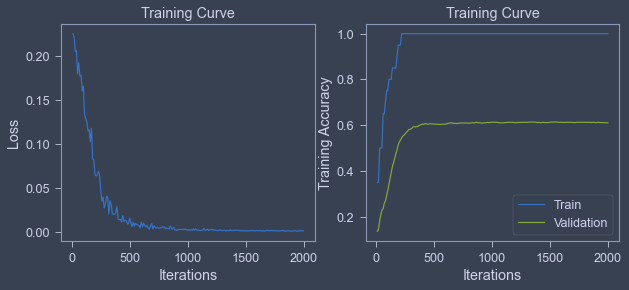

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.610204081632653


In [23]:
model = MNISTClassifier_Dropout().to(device)
train(model, mnist_train, mnist_val, num_epochs=1000)

+ Poprawa o 0.001!

## Weight decay
+ Polega na regularyzacji zmian wag.
+ Mamy dodanie kary za zbyt duże wagi.
+ W torch podajemy do optymalizatora parametr weight_decay - za ile mnożymy karę L2.

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900


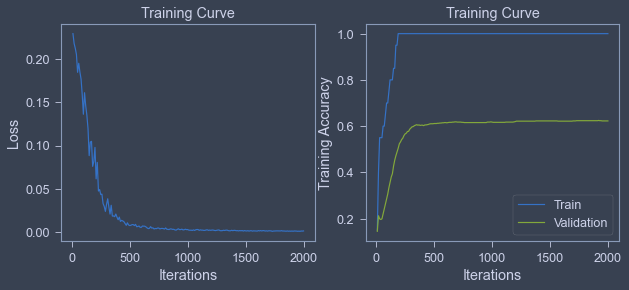

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.6224489795918368


In [24]:
model = MNISTClassifier().to(device)
train(model, mnist_train, mnist_val, num_epochs=1000, weight_decay=0.001)

+ Poprawa wyniku o 0.01!

## Wymyślenie własnej regularyzacji

In [51]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 800)
        self.act_1 =  nn.Tanh()
        self.layer2 = nn.Linear(800, 800)
        self.act_2 = nn.Tanh()
        self.layer3 = nn.Linear(800, 10)
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        activation1 = self.act_1(self.layer1(flattened))
        activation2 = self.act_2(self.layer2(activation1))
        output = self.layer3(activation2)
        return output

In [54]:
model = MNISTClassifier().to(device)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=128, shuffle=True) # shuffle after every epoch
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900


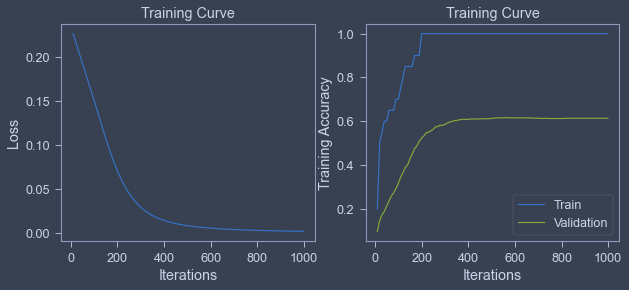

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.6142857142857143


In [55]:
iters, losses, train_acc, val_acc = [], [], [], []

idx = 0
for n in range(1000):
    for imgs, labels in iter(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        model.train() 
        out = model(imgs)             
        #-----------------------------------------------------------#

        regularization=0
        for param in model.parameters():
            regularization += torch.max(param**4)
        regularization = 0.1 * regularization
        # compute the total loss as a sum of loss + regularization
        loss = criterion(out, labels) + regularization
        #-----------------------------------------------------------#
        loss.backward()               
        optimizer.step()              
        optimizer.zero_grad()         

        if idx % 10 == 9:
            iters.append(idx)
            losses.append(float(loss)/10)        # compute *average* loss
            train_acc.append(get_accuracy(model, mnist_train)) # compute training accuracy 
            val_acc.append(get_accuracy(model, mnist_val))   # compute validation accuracy
        idx+=1
    if n%100==0:
        print(f"Epoch {n}")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Training Curve")
plt.plot(iters, losses, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.title("Training Curve")
plt.plot(iters, train_acc, label="Train")
plt.plot(iters, val_acc, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()


print("Final Training Accuracy: {}".format(train_acc[-1]))
print("Final Validation Accuracy: {}".format(val_acc[-1]))

# Wielkość sieci a jej jakość

In [10]:
class MNISTClassifier_parametrized(nn.Module):
    def __init__(self,size_1,size_2):
        super(MNISTClassifier_parametrized, self).__init__()
        self.layer1 = nn.Linear(28 * 28, size_1)
        self.act_1 =  nn.Tanh()
        self.layer2 = nn.Linear(size_1, size_2)
        self.act_2 = nn.Tanh()
        self.layer3 = nn.Linear(size_2, 10)
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        activation1 = self.act_1(self.layer1(flattened))
        activation2 = self.act_2(self.layer2(activation1))
        output = self.layer3(activation2)
        return output

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900


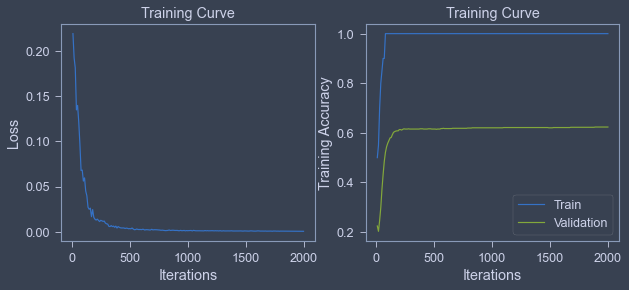

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.6234693877551021


In [57]:
model = MNISTClassifier_parametrized(5000,3000).to(device)
train(model, mnist_train, mnist_val, num_epochs=1000)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900


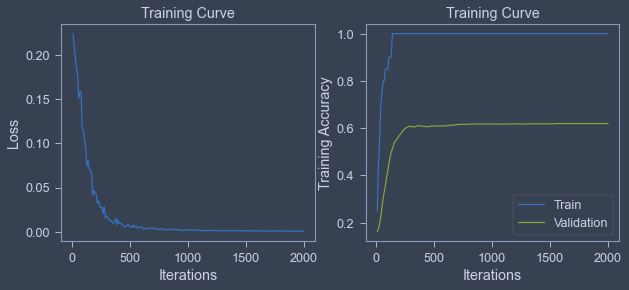

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.6193877551020408


In [58]:
model = MNISTClassifier_parametrized(2000,1000).to(device)
train(model, mnist_train, mnist_val, num_epochs=1000)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900


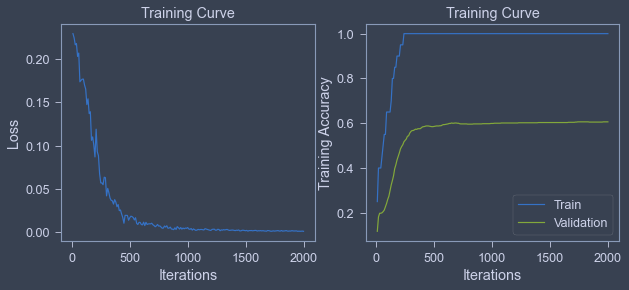

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.6061224489795919


In [59]:
model = MNISTClassifier_parametrized(1000,100).to(device)
train(model, mnist_train, mnist_val, num_epochs=1000)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900


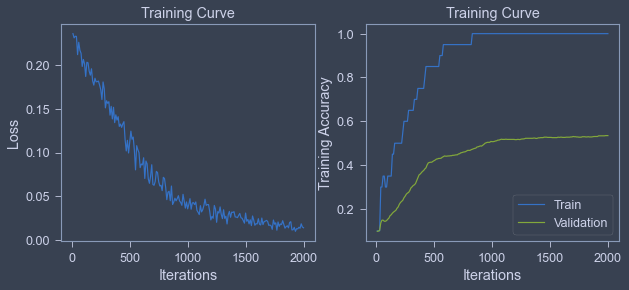

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.5346938775510204


In [60]:
model = MNISTClassifier_parametrized(20,10).to(device)
train(model, mnist_train, mnist_val, num_epochs=1000)

+ Zauważmy, że wraz ze zmniejszaniem się rozmiaru sieci, uczenie jej zajmuje zdecydowanie mniej czasu, jednak dokładność również maleje.

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900
Epoch 2000
Epoch 2100
Epoch 2200
Epoch 2300
Epoch 2400
Epoch 2500
Epoch 2600
Epoch 2700
Epoch 2800
Epoch 2900
Epoch 3000
Epoch 3100
Epoch 3200
Epoch 3300
Epoch 3400
Epoch 3500
Epoch 3600
Epoch 3700
Epoch 3800
Epoch 3900
Epoch 4000
Epoch 4100
Epoch 4200
Epoch 4300
Epoch 4400
Epoch 4500
Epoch 4600
Epoch 4700
Epoch 4800
Epoch 4900


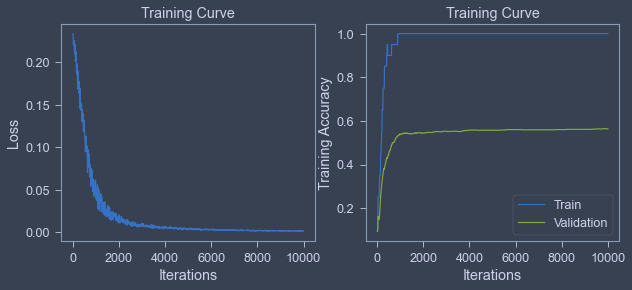

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.563265306122449


In [61]:
model = MNISTClassifier_parametrized(20,10).to(device)
train(model, mnist_train, mnist_val, num_epochs=5000)

+ Ale przy zmniejszeniu sieci można zawsze zwiększyć liczbę epok!


# Przeszukiwanie hiperparametrów

+ Czyszczenie pamięci cache GPU:

In [15]:
# fast accuracy on full dataset
def fast_accuracy(model, data):
    with torch.no_grad():
        correct = 0
        total = 0
        model.eval()
        imgs, labels = data
        output = model(imgs.to(device))
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred).to(device)).sum().item()
        total += imgs.shape[0]
    return correct / total


def train_search(model, train, valid, batch_size=10, num_epochs=1, learn_rate=0.001, weight_decay=0):
    train_loader = torch.utils.data.DataLoader(train,
                                               batch_size=batch_size,
                                               shuffle=True) # shuffle after every epoch
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learn_rate,momentum=0.9, weight_decay=weight_decay)

    iters, losses, train_acc, val_acc = [], [], [], []

    idx = 0
    for n in range(num_epochs):
        for imgs, labels in iter(train_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            model.train()
            out = model(imgs)            
            loss = criterion(out, labels) 
            loss.backward()               
            optimizer.step()              
            optimizer.zero_grad()         

    return(fast_accuracy(model, valid))

In [16]:
mnist_val_preprocessed = torch.cat([batch[0] for batch in mnist_val]), torch.tensor([batch[1] for batch in mnist_val])
mnist_data = torchvision.datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)
mnist_train = mnist_data[:20]
mnist_val   = mnist_data[20:10000] 

+ Grid search - przeszukujemy kombinacje hiperparametrów:

In [17]:
first_layer = [5000, 2000, 1000, 500, 100, 50, 10]
second_layer = [5000, 2000, 1000, 500, 100, 50, 10]
results = pd.DataFrame()
for i in range(len(first_layer)):
    for j in range(len(second_layer)):
        model = MNISTClassifier_parametrized(first_layer[i],second_layer[j]).to(device)
        print(f"{i=}, {j=}")
        val_acc = train_search(model, mnist_train, mnist_val_preprocessed, num_epochs=1000)
        print(first_layer[i],second_layer[j],val_acc)
        results = results.append({"first": first_layer[i], "second": second_layer[j],"acc":val_acc},ignore_index=True)
        torch.cuda.empty_cache()

i=0, j=0
5000 5000 0.5930861723446894
i=0, j=1
5000 2000 0.5870741482965932
i=0, j=2
5000 1000 0.5917835671342685
i=0, j=3
5000 500 0.5938877755511022
i=0, j=4
5000 100 0.5829659318637275
i=0, j=5
5000 50 0.57625250501002
i=0, j=6
5000 10 0.5447895791583166
i=1, j=0
2000 5000 0.5891783567134269
i=1, j=1
2000 2000 0.587374749498998
i=1, j=2
2000 1000 0.5850701402805611
i=1, j=3
2000 500 0.5872745490981964
i=1, j=4
2000 100 0.5789579158316633
i=1, j=5
2000 50 0.5793587174348698
i=1, j=6
2000 10 0.5432865731462926
i=2, j=0
1000 5000 0.5879759519038076
i=2, j=1
1000 2000 0.5888777555110221
i=2, j=2
1000 1000 0.5987975951903808
i=2, j=3
1000 500 0.5872745490981964
i=2, j=4
1000 100 0.591182364729459
i=2, j=5
1000 50 0.5681362725450901
i=2, j=6
1000 10 0.574749498997996
i=3, j=0
500 5000 0.5867735470941884
i=3, j=1
500 2000 0.5840681362725451
i=3, j=2
500 1000 0.6022044088176353
i=3, j=3
500 500 0.5892785571142285
i=3, j=4
500 100 0.5841683366733467
i=3, j=5
500 50 0.5796593186372746
i=3, j=

In [18]:
# results.to_csv("params_search.csv",index=False)
results = pd.read_csv("params_search.csv")

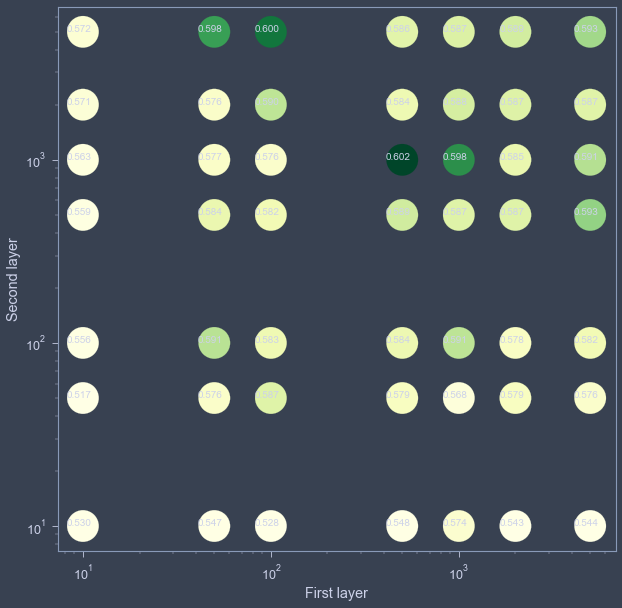

In [19]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(results["first"], results["second"], c=np.exp(results.acc*100), cmap="YlGn", s=1000)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("First layer")
plt.ylabel("Second layer")
for idx, row in results.iterrows():
    ax.annotate(str(row.acc)[:5], (row["first"]*0.82, row["second"]))
plt.show()

In [20]:
class MNISTClassifier_parametrized_3(nn.Module):
    def __init__(self,size_1,size_2, size_3):
        super(MNISTClassifier_parametrized_3, self).__init__()
        self.layer1 = nn.Linear(28 * 28, size_1)
        self.act_1 =  nn.Tanh()
        self.layer2 = nn.Linear(size_1, size_2)
        self.act_2 = nn.Tanh()
        self.layer3 = nn.Linear(size_2, size_3)
        self.act_3 = nn.Tanh()
        self.layer4 = nn.Linear(size_3, 10)
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        activation1 = self.act_1(self.layer1(flattened))
        activation2 = self.act_2(self.layer2(activation1))
        activation3 = self.act_3(self.layer3(activation2))
        output = self.layer4(activation3)
        return output

## Sieć o większej liczbie warstw wymaga dłuższego treningu

Epoch 0


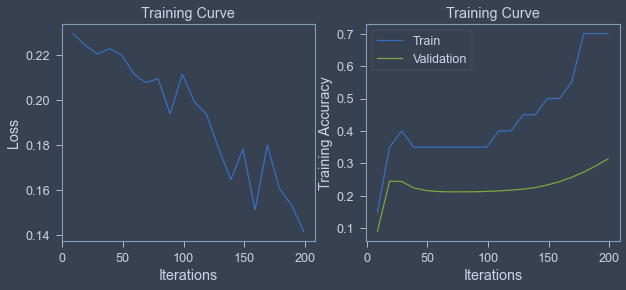

Final Training Accuracy: 0.7
Final Validation Accuracy: 0.3137274549098196


In [25]:
model = MNISTClassifier_parametrized_3(1000,500,100).to(device)
train(model, mnist_train, mnist_val, num_epochs=100)

Epoch 0


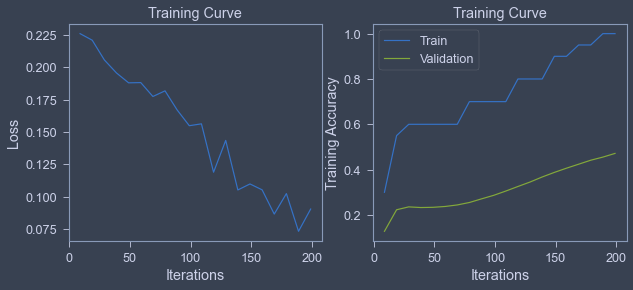

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.4715430861723447


In [26]:
model = MNISTClassifier_parametrized(1000,500).to(device)
train(model, mnist_train, mnist_val, num_epochs=100)

## Większa liczba warstw może prowadzić do przeuczania

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900
Epoch 2000
Epoch 2100
Epoch 2200
Epoch 2300
Epoch 2400
Epoch 2500
Epoch 2600
Epoch 2700
Epoch 2800
Epoch 2900


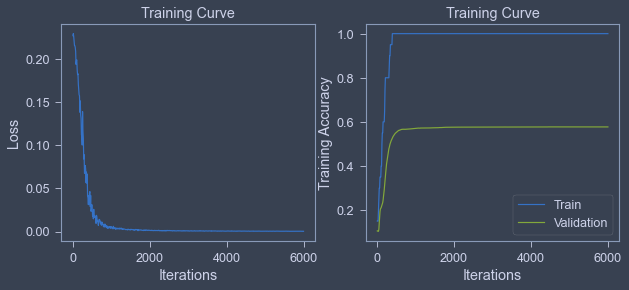

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.5770541082164329


In [27]:
model = MNISTClassifier_parametrized_3(1000,500,100).to(device)
train(model, mnist_train, mnist_val, num_epochs=3000)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900
Epoch 2000
Epoch 2100
Epoch 2200
Epoch 2300
Epoch 2400
Epoch 2500
Epoch 2600
Epoch 2700
Epoch 2800
Epoch 2900


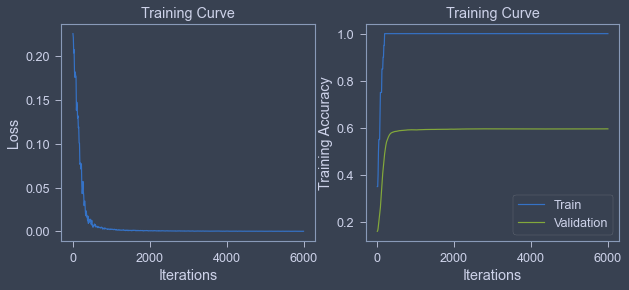

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.5952905811623247


In [28]:
model = MNISTClassifier_parametrized(1000,500).to(device)
train(model, mnist_train, mnist_val, num_epochs=3000)

# Reprezentacja danych

In [29]:
adults_data_orig = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",header=None)

In [30]:
adults_data = adults_data_orig.copy()

In [31]:
adults_data.columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "label"]

In [32]:
adults_data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [33]:
adults_data.drop(columns=["native-country","education","workclass","relationship", "marital-status","race"],inplace=True)

In [34]:
adults_data

,age,fnlwgt,education-num,occupation,sex,capital-gain,capital-loss,hours-per-week,label
0,39,77516,13,Adm-clerical,Male,2174,0,40,<=50K
1,50,83311,13,Exec-managerial,Male,0,0,13,<=50K
2,38,215646,9,Handlers-cleaners,Male,0,0,40,<=50K
3,53,234721,7,Handlers-cleaners,Male,0,0,40,<=50K
4,28,338409,13,Prof-specialty,Female,0,0,40,<=50K
...,...,...,...,...,...,...,...,...,...
32556,27,257302,12,Tech-support,Female,0,0,38,<=50K
32557,40,154374,9,Machine-op-inspct,Male,0,0,40,>50K
32558,58,151910,9,Adm-clerical,Female,0,0,40,<=50K
32559,22,201490,9,Adm-clerical,Male,0,0,20,<=50K


+ Zamiana binarnych kolumn tekstowych na 0 i 1:

In [35]:
adults_data.sex = (adults_data.sex==' Male').astype(int)
adults_data.label = (adults_data.label==' >50K').astype(int)

In [36]:
adults_data

,age,fnlwgt,education-num,occupation,sex,capital-gain,capital-loss,hours-per-week,label
0,39,77516,13,Adm-clerical,1,2174,0,40,0
1,50,83311,13,Exec-managerial,1,0,0,13,0
2,38,215646,9,Handlers-cleaners,1,0,0,40,0
3,53,234721,7,Handlers-cleaners,1,0,0,40,0
4,28,338409,13,Prof-specialty,0,0,0,40,0
...,...,...,...,...,...,...,...,...,...
32556,27,257302,12,Tech-support,0,0,0,38,0
32557,40,154374,9,Machine-op-inspct,1,0,0,40,1
32558,58,151910,9,Adm-clerical,0,0,0,40,0
32559,22,201490,9,Adm-clerical,1,0,0,20,0


+ Kategoryczne kolumny - zamieniaja mozliwe kategorie na kolumny:

In [37]:
categorical_columns = ["occupation"]
categorical_values = pd.get_dummies(adults_data[categorical_columns])
categorical_values.head()

,occupation_ ?,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [38]:
adults_data.drop(columns=categorical_columns,inplace=True)

In [39]:
adults_data

,age,fnlwgt,education-num,sex,capital-gain,capital-loss,hours-per-week,label
0,39,77516,13,1,2174,0,40,0
1,50,83311,13,1,0,0,13,0
2,38,215646,9,1,0,0,40,0
3,53,234721,7,1,0,0,40,0
4,28,338409,13,0,0,0,40,0
...,...,...,...,...,...,...,...,...
32556,27,257302,12,0,0,0,38,0
32557,40,154374,9,1,0,0,40,1
32558,58,151910,9,0,0,0,40,0
32559,22,201490,9,1,0,0,20,0


+ Klasyfikacja zarobków:

In [48]:
train_indices = np.random.rand(len(adults_data))>0.3

In [49]:
numerical_data = torch.from_numpy(adults_data.values[train_indices,:-1]).float()
categorical_data = torch.from_numpy(categorical_values.values[train_indices]).float()
targets = torch.from_numpy(adults_data.values[train_indices,-1]).float()

test_numerical_data = torch.from_numpy(adults_data.values[~train_indices,:-1]).float()
test_categorical_data = torch.from_numpy(categorical_values.values[~train_indices]).float()
test_targets = torch.from_numpy(adults_data.values[~train_indices,-1]).float()

In [50]:
train_dataset = data.TensorDataset(numerical_data,categorical_data,targets)
test_dataset = data.TensorDataset(test_numerical_data,test_categorical_data,test_targets)

In [51]:
class Adults_classifier(nn.Module):
    def __init__(self):
        super(Adults_classifier, self).__init__()
         # wejscie to laczenie kolumny numerycznej i kolumny kategorycznej
        self.layer1 = nn.Linear(adults_data.shape[1] + categorical_data.shape[1] -1, 40)
        self.act_1 = nn.LeakyReLU()
        self.d1 = nn.Dropout(0.4)
        self.layer2 = nn.Linear(40, 20)
        self.act_2 = nn.LeakyReLU()
        self.d2 = nn.Dropout(0.4)
        self.layer3 = nn.Linear(20, 1)
    def forward(self, x, cat_x):
        x = torch.cat([x,cat_x],dim=1)
        activation1 = self.act_1(self.layer1(x))
        activation1 = self.d1(activation1)
        activation2 = self.act_2(self.layer2(activation1))
        activation2 = self.d1(activation2)
        output = self.layer3(activation2)
        return output

In [52]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    model.eval() #*********#
    for x, cat_x, labels in data_loader:
        x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
        output = model(x, cat_x)
        pred = output>0
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += x.shape[0]
    return correct / total

In [53]:
model = Adults_classifier().to(device)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

iters = []
losses = []
train_acc = []
val_acc = []
for n in range(10):
    epoch_losses = []
    for x, cat_x, labels in iter(train_loader):
        x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
        model.train() 
        out = model(x, cat_x).squeeze()           

        loss = criterion(out, labels)
        loss.backward()  
        epoch_losses.append(loss.item())
        optimizer.step()              
        optimizer.zero_grad()         

    loss_mean = np.array(epoch_losses).mean()
    iters.append(n)
    losses.append(loss_mean)
    test_acc = get_accuracy(model, test_loader)
    print(f"Epoch {n} loss {loss_mean:.3} test_acc: {test_acc:.3}")
    train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
    val_acc.append(test_acc)  # compute validation accuracy
        

print("Final Training Accuracy: {}".format(train_acc[-1]))
print("Final Validation Accuracy: {}".format(val_acc[-1]))

Epoch 0 loss 1.62e+02 test_acc: 0.765
Epoch 1 loss 11.4 test_acc: 0.765
Epoch 2 loss 6.74 test_acc: 0.766
Epoch 3 loss 4.01 test_acc: 0.767
Epoch 4 loss 2.45 test_acc: 0.769
Epoch 5 loss 1.47 test_acc: 0.771
Epoch 6 loss 0.952 test_acc: 0.772
Epoch 7 loss 0.744 test_acc: 0.772
Epoch 8 loss 0.639 test_acc: 0.768
Epoch 9 loss 0.607 test_acc: 0.769
Final Training Accuracy: 0.7673250021847418
Final Validation Accuracy: 0.7693023255813953


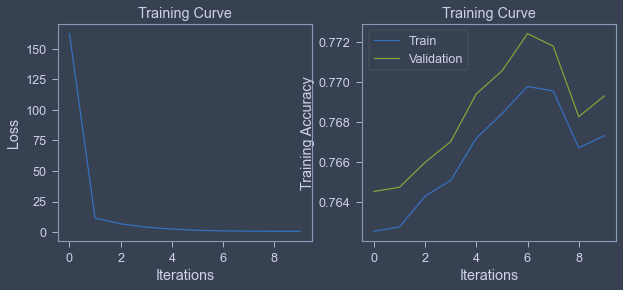

In [54]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Training Curve")
plt.plot(iters, losses, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.title("Training Curve")
plt.plot(iters, train_acc, label="Train")
plt.plot(iters, val_acc, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()

## Embeddingi

+ Lepsza wersja enconde'owania.
+ Umieszczamy zawód w przestrzeni wielowymiarowej, a tak że obok siebie są podobne zawody.
+ Robimy to za pomocą sieci neuronowej.

In [55]:
class Adults_classifier_embeddings(nn.Module):
    def __init__(self):
        super(Adults_classifier_embeddings, self).__init__()
        # separated layer kxk processing categorical data
        self.emb_layer = nn.Linear(categorical_data.shape[1], categorical_data.shape[1])
        self.act_emb = nn.Tanh()
        self.layer1 = nn.Linear(adults_data.shape[1] - 1 + categorical_data.shape[1], 40)
        self.act_1 =  nn.LeakyReLU()
        self.d1 = nn.Dropout(0.4)
        self.layer2 = nn.Linear(40, 20)
        self.act_2 =  nn.LeakyReLU()
        self.d2 = nn.Dropout(0.4)
        self.layer3 = nn.Linear(20, 1)
        
    def forward(self, x, cat_x):
        cat_x_embedded = self.emb_layer(cat_x)
        cat_x_embedded = self.act_emb(cat_x_embedded)
        x = torch.cat([x,cat_x_embedded],dim=1)       # konkatenacja wej i warstwy embeddingu
        activation1 = self.act_1(self.layer1(x))
        activation1 = self.d1(activation1)
        activation2 = self.act_2(self.layer2(activation1))
        activation2 = self.d2(activation2)
        output = self.layer3(activation2)
        return output

In [56]:
model = Adults_classifier_embeddings().to(device)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

iters = []
losses = []
train_acc = []
val_acc = []
for n in range(10):
    epoch_losses = []
    for x, cat_x, labels in iter(train_loader):
        x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
        model.train() 
        out = model(x, cat_x).squeeze()           

        loss = criterion(out, labels)
        loss.backward()  
        epoch_losses.append(loss.item())
        optimizer.step()              
        optimizer.zero_grad()         

    loss_mean = np.array(epoch_losses).mean()
    iters.append(n)
    losses.append(loss_mean)
    test_acc = get_accuracy(model, test_loader)
    print(f"Epoch {n} loss {loss_mean:.3} test_acc: {test_acc:.3}")
    train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
    val_acc.append(test_acc)  # compute validation accuracy
        

print("Final Training Accuracy: {}".format(train_acc[-1]))
print("Final Validation Accuracy: {}".format(val_acc[-1]))

Epoch 0 loss 1.41e+02 test_acc: 0.771
Epoch 1 loss 9.01 test_acc: 0.765
Epoch 2 loss 4.62 test_acc: 0.764
Epoch 3 loss 1.84 test_acc: 0.762
Epoch 4 loss 0.731 test_acc: 0.76
Epoch 5 loss 0.605 test_acc: 0.76
Epoch 6 loss 0.591 test_acc: 0.76
Epoch 7 loss 0.584 test_acc: 0.758
Epoch 8 loss 0.587 test_acc: 0.76
Epoch 9 loss 0.585 test_acc: 0.76
Final Training Accuracy: 0.7589355938128113
Final Validation Accuracy: 0.7603100775193798


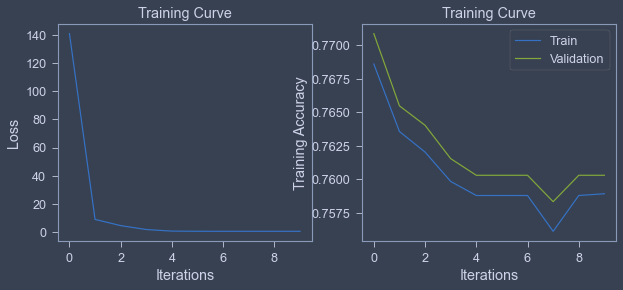

In [57]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Training Curve")
plt.plot(iters, losses, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.title("Training Curve")
plt.plot(iters, train_acc, label="Train")
plt.plot(iters, val_acc, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()

+ Dlaczego tak się dzieje - predykcje o jednej wartości przeważają:

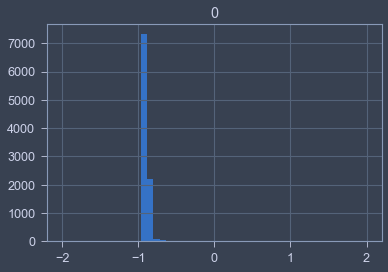

In [59]:
preds = model(test_numerical_data.to(device),test_categorical_data.to(device))
pd.DataFrame(preds.cpu().detach().numpy()).hist(bins=50, range=(-2,2));

In [60]:
(preds>0).sum()

tensor(1, device='cuda:0')

# Ważenie przykładów
+ Chcemy więc w dobry sposób przeskalować liczbę klas - będziemy ważyć liczby etykiet.

+ Metoda pozwalająca ważyć liczby etykiet - ważenie funkcji straty osobno dla klas i mnozenie funkcji straty dla przykladow ktorych jest mniej.

In [61]:
model = Adults_classifier_embeddings().to(device)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)
criterion = nn.BCEWithLogitsLoss(pos_weight=(len(targets)-sum(targets))/sum(targets))    # parametr pos_weight - stosunek zer do jedynek
optimizer = optim.Adam(model.parameters(), lr=0.001)

iters = []
losses = []
train_acc = []
val_acc = []
for n in range(30):
    epoch_losses = []
    for x, cat_x, labels in iter(train_loader):
        x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
        model.train() 
        out = model(x, cat_x).squeeze()           

        loss = criterion(out, labels)
        loss.backward()  
        epoch_losses.append(loss.item())
        optimizer.step()              
        optimizer.zero_grad()         

    loss_mean = np.array(epoch_losses).mean()
    iters.append(n)
    losses.append(loss_mean)
    test_acc = get_accuracy(model, test_loader)
    print(f"Epoch {n} loss {loss_mean:.3} test_acc: {test_acc:.3}")
    train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
    val_acc.append(test_acc)  # compute validation accuracy
        

print("Final Training Accuracy: {}".format(train_acc[-1]))
print("Final Validation Accuracy: {}".format(val_acc[-1]))

Epoch 0 loss 2.67e+02 test_acc: 0.24
Epoch 1 loss 30.1 test_acc: 0.313
Epoch 2 loss 14.8 test_acc: 0.771
Epoch 3 loss 6.76 test_acc: 0.313
Epoch 4 loss 2.91 test_acc: 0.766
Epoch 5 loss 1.55 test_acc: 0.766
Epoch 6 loss 1.16 test_acc: 0.766
Epoch 7 loss 1.13 test_acc: 0.248
Epoch 8 loss 1.12 test_acc: 0.24
Epoch 9 loss 1.11 test_acc: 0.764
Epoch 10 loss 1.13 test_acc: 0.24
Epoch 11 loss 1.13 test_acc: 0.24
Epoch 12 loss 1.13 test_acc: 0.321
Epoch 13 loss 1.14 test_acc: 0.771
Epoch 14 loss 1.14 test_acc: 0.764
Epoch 15 loss 1.12 test_acc: 0.759
Epoch 16 loss 1.12 test_acc: 0.732
Epoch 17 loss 1.11 test_acc: 0.768
Epoch 18 loss 1.1 test_acc: 0.24
Epoch 19 loss 1.1 test_acc: 0.784
Epoch 20 loss 1.09 test_acc: 0.78
Epoch 21 loss 1.07 test_acc: 0.793
Epoch 22 loss 1.06 test_acc: 0.795
Epoch 23 loss 1.03 test_acc: 0.793
Epoch 24 loss 1.02 test_acc: 0.453
Epoch 25 loss 1.06 test_acc: 0.456
Epoch 26 loss 1.02 test_acc: 0.79
Epoch 27 loss 0.992 test_acc: 0.79
Epoch 28 loss 0.989 test_acc: 0.788

+ Nastąpiło zwiększenie dokładności modelu :)

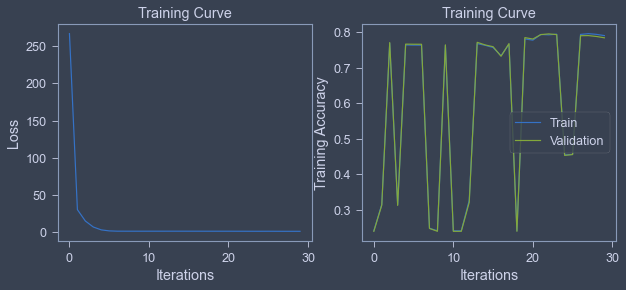

In [62]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Training Curve")
plt.plot(iters, losses, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.title("Training Curve")
plt.plot(iters, train_acc, label="Train")
plt.plot(iters, val_acc, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()

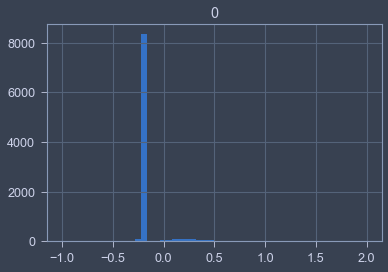

In [63]:
preds = model(test_numerical_data.to(device),test_categorical_data.to(device))
pd.DataFrame(preds.cpu().detach().numpy()).hist(bins=50, range=(-1,2));

In [64]:
(preds>0).sum()

tensor(1181, device='cuda:0')